# Identifeye ML Engineering Challenge

Thank you for spending time on this take-home! We are delighted that you are considering a machine learning role at Identifeye Health. In this exam, you will solve a problem with immediate relevance to us: developing a model for predicting the quality of captured fundus images

## Context:

Doctors rely heavily on good quality images to confidently diagnose diseases and conditions. Thus, it is important to evaluate the quality of a captured image, namely checking that it is artifact free, has the right color balance and the required anatomical features visible, and so on. When an image quality is evaluated to be insufficient, the patient will recapture it to increase the chances of having an image that the doctor is able to interpret reliably. This is one challenge to which we apply machine learning!

Fundus imaging is a well-established retinal imaging technique. Diagnosis is done through the inspection of the optic disc, the macula, and blood vessels. In a good quality image, all these main retinal elements need to be clearly visible, depending on where the image is centered. Additionally, other quality parameters determine the overall usability of the image for interpretation such as illumination uniformity, blur, color balance, contrast, field definition and the presence of artifacts. Below, we show sample bad quality images with their labels in the title, as well as a set of good quality images.


<center> <h3>Bad Quality Images</h3> </center>

 Dust | Eye Blink | Artifact
 :- | :- | :- 
 ![alt](Data/examples/dust.png) | ![alt](Data/examples/eye_blink.png) | ![alt](Data/examples/artifact3.jpg)

Overexposed | Underexposed |  Uneven Illumination
:- | :- | :- 
![alt](Data/examples/overexposed.png) | ![alt](Data/examples/underexposed.png) | ![alt](Data/examples/unevenillum.png)



<center> <h3>Good Quality Images</h3> </center>


Right Eye | Left Eye | Left Eye  
:- | :- | :- 
![alt](Data/examples/8664_right.png) | ![alt](Data/examples/9288_left.png) | ![alt](Data/examples/978_left.png) 

Right Eye | Right Eye | Left Eye 
:- | :- | :- 
![alt](Data/examples/1034_right.png) | ![alt](Data/examples/10457_right.png) | ![alt](Data/examples/11618_left.png) 




## Challenge

**Based on this use case, your assignment is to build a model to predict the quality label of an image.** You have been given images of good (label 0) and bad quality (label 1). We have structured the assignment so that you work with incremental components of the problem in a way that gets you to a more complete understanding. Please make sure to read the directions in each steps!

As you go through this task, it is suggested that you prioritize **exploratory data analysis and principled model selection**. You are also encouraged to consider alternatives to methods you may try and suggest them as future work to explore.

## Ground Rules/Expectations

* You **are not** expected, within the limited time frame, to solve this problem entirely and invent a new way of analyzing image quality. We understand that you have a busy life, and have thus capped the amount of time you can spend on this problem to 3 hours. So, don't prioritize just getting the best performing model for each step!
* You **are** expected to communicate your overarching approach to the problem and the components we have laid out, with clear articulation of answers and presentation of supporting data (tables, plots, etc). So, do walk us through and explain how you used the available data to draw appropriate conclusions!
* You are welcome to use any open-source libraries that you would like. 


## Data

This folder consists of two components:

1. 1300 .pngs in the "fundus" folder consisting of fundus images of varying image quality
2. Two csv files containing the image name and quality label
    - Simple model subset
    
        - This file contains 300 image names and their quality labels. You will be using this subset in the first section of the assignment. Quality labels are good(0) and bad (1). The accuracy of the labels in this subset is confirmed by medically trained professionals. 
        
    - CNN subset
    
        - This file contains 1000 image names and their quality labels. Note that CNN subset does not contain any images that were listed in the simple model subset. Quality labels are good(0) and bad (1). 

Use this data to work through this assignment.

## Rubric

In evaluating this assignment, we will consider the following skills:
1. demonstration of applied ML process
2. coding style and conventions
3. ability to thoughtfully communicate rationale, methods, and next steps

Best of luck!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r '/content/drive/MyDrive/SRIP(Ophthalmology)/Identifeye ML Challenge_2023' ./

# Step 0: Exploratory Data Analysis

Explore the data and share your insights!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import cv2
import os

from PIL import Image
from collections import defaultdict
from tqdm import tqdm
from datetime import datetime
from random import shuffle

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve,balanced_accuracy_score,f1_score,classification_report

### Define the paths for the dataset 

In [2]:
data_path = os.path.join(os.getcwd(),'Identifeye ML Challenge_2023',pathlib.Path("Data") )
image_path = os.path.join(data_path,  'fundus_images')
simple_model_subset_path = os.path.join(data_path, 'simple_model_subset.csv')
cnn_subset_path = os.path.join(data_path, 'cnn_subset.csv')


In [3]:
## printing all the paths to recheck them

data_path,image_path,simple_model_subset_path,cnn_subset_path

('/content/Identifeye ML Challenge_2023/Data',
 '/content/Identifeye ML Challenge_2023/Data/fundus_images',
 '/content/Identifeye ML Challenge_2023/Data/simple_model_subset.csv',
 '/content/Identifeye ML Challenge_2023/Data/cnn_subset.csv')

### Load the label files

In [4]:
simple_model_subset = pd.read_csv(simple_model_subset_path, index_col=0)

cnn_subset = pd.read_csv(cnn_subset_path, index_col=0)


In [5]:
print(simple_model_subset)
print(cnn_subset)

               image  quality
0    10218_right.png        1
1     10230_left.png        1
2    10255_right.png        1
3     1034_right.png        0
4    10457_right.png        0
..               ...      ...
295    9278_left.png        1
296    9288_left.png        0
297    9353_left.png        1
298   9767_right.png        1
299     978_left.png        0

[300 rows x 2 columns]
               image  quality
0     10218_left.png        1
1    10230_right.png        1
2    10234_right.png        1
3     10340_left.png        0
4    10391_right.png        0
..               ...      ...
995    994_right.png        0
996    9942_left.png        0
997    9976_left.png        0
998   9979_right.png        1
999    9992_left.png        1

[1000 rows x 2 columns]


### Define a function for loading images

In [6]:
def load_images(img_dir,csv_dir):
  '''
  Loads images based on the images directory and csv directory
  '''

  assert isinstance(img_dir,str), "Image directory path should be string type"
  assert isinstance(csv_dir,str), "CSV directory path should be string type"

  # dataframe for storing the information
  img_dict = {}
  label_dict = {}

  df = pd.read_csv(csv_dir, index_col=0)

  # iterating over all the rows in the dataframe
  for index, row in tqdm(df.iterrows()):

    filename,label = row['image'],row['quality']
    
    # final image path for loading
    img_filepath = os.path.join(img_dir,filename)

    label_dict[filename] = label
    img_dict[filename] = np.array(Image.open(img_filepath)) # reading img

  return img_dict,label_dict

# # testing code
# t1,t2 = load_images(image_path,simple_model_subset_path)

In [7]:
img_di,label_di = load_images(image_path,simple_model_subset_path)

300it [00:05, 53.48it/s]


### Define a function for plotting sample images with their labels 

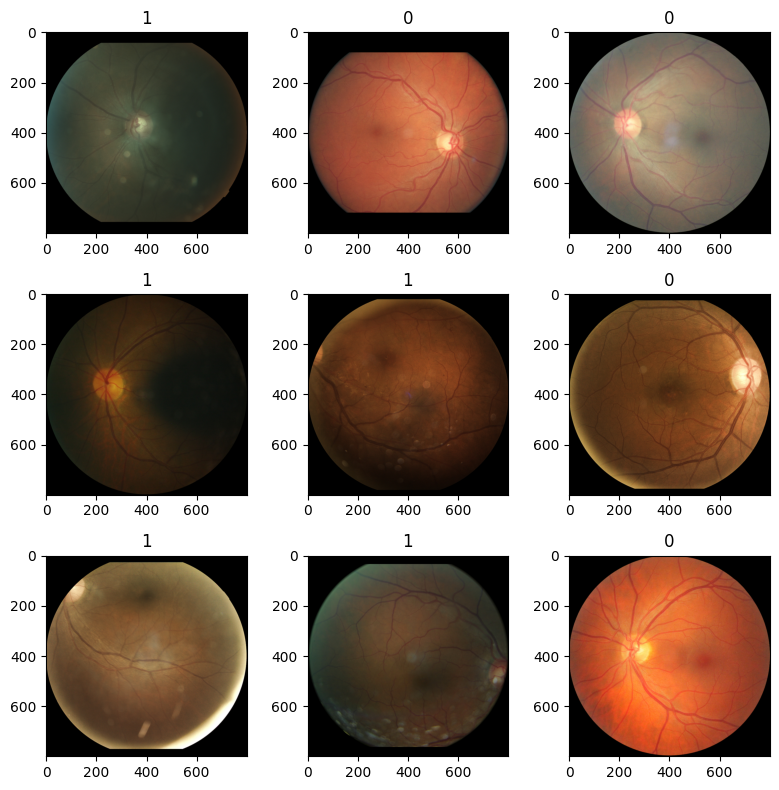

In [10]:
def plot_random_imgs(num_imgs,img_di,label_di,label_type = -1):

  '''
  Function for plotting images with labels 

  label_type = -1 -> mix of both the labels
  label_type = 1  -> images with 1 as labels
  label_type = 0  -> images with 0 as labels
  '''
  
  assert isinstance(num_imgs,int), "Number of images should be integer type"
  assert num_imgs > 0 , 'Number of images should be greater than zero'

  assert len(img_di) == len(label_di), "img_di and label_di should contain same number of samples"
  assert isinstance(img_di, dict), "img_di should be dictionary type"
  assert isinstance(label_di,dict), "label_di should be dictionary type"

  num_cols = int(np.ceil(np.sqrt(num_imgs)))
  num_rows = int(np.ceil(num_imgs / num_cols))

  fig, axs = plt.subplots(num_cols, num_rows, figsize=(8, 8))
  axs = axs.flatten()

  if label_type == -1:
    labels = list(img_di.keys())

  elif label_type == 0:
    label_0 = [filename for filename,label in label_di.items() if label == 0]
    labels = label_0

  elif label_type == 1:
    label_1 = [filename for filename,label in label_di.items() if label == 1]
    labels = label_1
    
  shuffle(labels) ### shuffling the labels

  for ind,label in enumerate(labels[:num_imgs]):
    # Add the image on the subplot
    axs[ind].imshow(img_di[label])  
    axs[ind].set_title(label_di[label])

  fig.tight_layout()
  plt.show()


## testing code
plot_random_imgs(9,img_di,label_di,label_type = -1)  ## plotting mixture of good and bad images

### Plot and observe the differences between the bad and good images on a data subset 

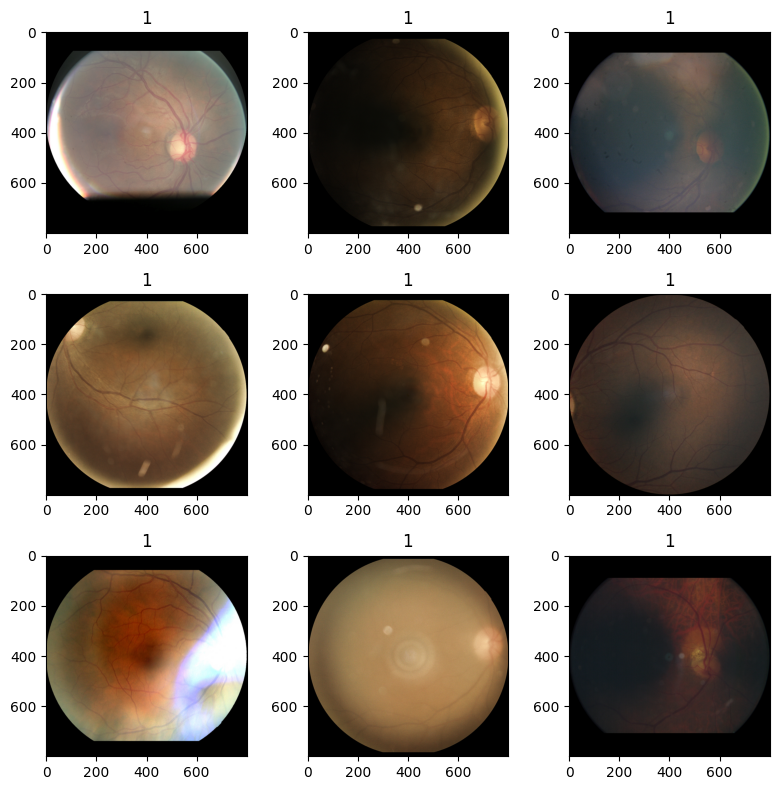

In [10]:
## plotting bad images

plot_random_imgs(9,img_di,label_di,label_type = 1)

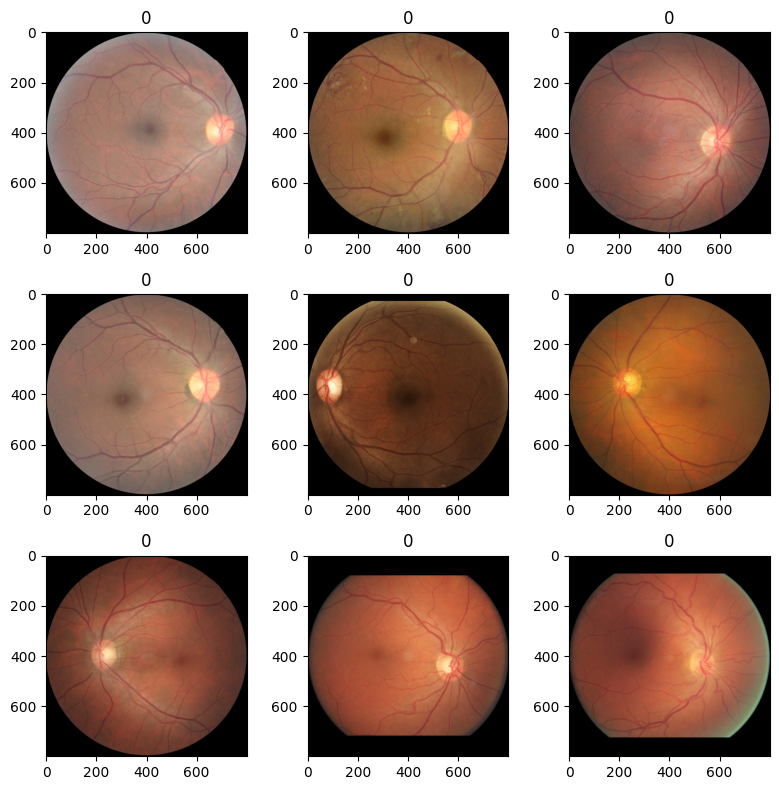

In [11]:
## plotting good images

plot_random_imgs(9,img_di,label_di,label_type = 0)

### Explore the Data 

In [12]:
simple_model_subset.head()

,image,quality
0,10218_right.png,1
1,10230_left.png,1
2,10255_right.png,1
3,1034_right.png,0
4,10457_right.png,0


In [13]:
cnn_subset.head()

,image,quality
0,10218_left.png,1
1,10230_right.png,1
2,10234_right.png,1
3,10340_left.png,0
4,10391_right.png,0


In [14]:
simple_model_subset['quality'].value_counts()

1    150
0    150
Name: quality, dtype: int64

In [15]:
cnn_subset['quality'].value_counts()

1    500
0    500
Name: quality, dtype: int64

In [16]:
### calculating image dims and chanels information by creating new dataframe

di_for_df = defaultdict(list)

data_frame = simple_model_subset

# iterating over all the rows in the dataframe
for index, row in tqdm(data_frame.iterrows()):

  filename,label = row['image'],row['quality']
  
  # final image path for loading
  img_filepath = os.path.join(image_path,filename)

  img = np.array(Image.open(img_filepath)) # reading img

  di_for_df['filename'].append(filename)
  di_for_df['label'].append(label)
  di_for_df['x_dims'].append(img.shape[0])
  di_for_df['y_dims'].append(img.shape[1])
  di_for_df['channel'].append(img.shape[2])
                                        
simple_model_subset_df = pd.DataFrame(di_for_df)
simple_model_subset_df.head()

300it [00:03, 77.83it/s]


,filename,label,x_dims,y_dims,channel
0,10218_right.png,1,800,800,3
1,10230_left.png,1,800,800,3
2,10255_right.png,1,800,800,3
3,1034_right.png,0,800,800,3
4,10457_right.png,0,800,800,3


In [17]:
simple_model_subset_df.describe()

,label,x_dims,y_dims,channel
count,300.000000,300.0,300.0,300.0
mean,0.500000,800.0,800.0,3.0
std,0.500835,0.0,0.0,0.0
min,0.000000,800.0,800.0,3.0
25%,0.000000,800.0,800.0,3.0
50%,0.500000,800.0,800.0,3.0
75%,1.000000,800.0,800.0,3.0
max,1.000000,800.0,800.0,3.0


In [18]:
#### All images in simple model subset has 3 channels and both the x and y dimensions are 800

In [19]:
### calculating image dims and chanels information by creating new dataframe

di_for_df = defaultdict(list)

data_frame = cnn_subset

# iterating over all the rows in the dataframe
for index, row in tqdm(data_frame.iterrows()):

  filename,label = row['image'],row['quality']
  
  # final image path for loading
  img_filepath = os.path.join(image_path,filename)

  img = np.array(Image.open(img_filepath)) # reading img

  di_for_df['filename'].append(filename)
  di_for_df['label'].append(label)
  di_for_df['x_dims'].append(img.shape[0])
  di_for_df['y_dims'].append(img.shape[1])
  di_for_df['channel'].append(img.shape[2])
                                        
cnn_subset_df = pd.DataFrame(di_for_df)
cnn_subset_df.head()

1000it [00:17, 58.39it/s]


,filename,label,x_dims,y_dims,channel
0,10218_left.png,1,800,800,3
1,10230_right.png,1,800,800,3
2,10234_right.png,1,800,800,3
3,10340_left.png,0,800,800,3
4,10391_right.png,0,800,800,3


In [20]:
simple_model_subset_df.describe()

,label,x_dims,y_dims,channel
count,300.000000,300.0,300.0,300.0
mean,0.500000,800.0,800.0,3.0
std,0.500835,0.0,0.0,0.0
min,0.000000,800.0,800.0,3.0
25%,0.000000,800.0,800.0,3.0
50%,0.500000,800.0,800.0,3.0
75%,1.000000,800.0,800.0,3.0
max,1.000000,800.0,800.0,3.0


In [21]:
#### All images in cnn model subset has 3 channels and both the x and y dimensions are 800

# Step 1: Simple Model 

Now that we gained insights about the dataset, we can start building models for predicting image quality. In this section, build a model for classifying the images into good and bad classes only using the small data subset. This subset has 300 images from good (label 0) and bad (label 1) classes. Given the size of the dataset, we do not expect you to train a neural network in this section. Feel free to use any other model you like. 

### Q: Define a model for training 

Tell us why you picked this model. What are the advantages/disadvantages?

### Your Answer:

I'm using logistic regresssion as a simple model for following reasons:

* It is one of the most simplest model which allows to interpret the results by looking at the weigts corresponding to each of the inputs.
* Logistic regression has low variance is less prone to overfitting which is plus when working with smaller datasets as it uses regularization parameter.
* Computationally, logistic regression is quick to train.
* It can inherently provide probabilitic outputs which is helpful in measuring mode's ability to distinguish between classes via AUC curve as well as analyze model's result.

### Q: Metrics

- Explain what metrics you will use for evaluating model performance. 
- If the task was multi level classification (good, accept, bad), what metrics would you be looking at?
- In the case where data is not evenly distributed accross classes, how would you modify the mentioned metrics or add other metrics to best present your model performance?

### Your Answer: 

* Since the dataset is balanced using Accuracy as a metric seems reasonable choice. It would measure the number of correct classification by the model from total number of records.

* If the task was multi level classification then we can still look at the classification metrics like accuracy or F1-score in a one-vs-all setting.

* In case where dataset is not balanced using AUC-ROC or F1 score would have been better choice since they account for class imbalance. One can also use macro-accuracy (weighs each class equally) based on the alignment with the business owners of the product.



### Q: Train & Test

Train/test the model of your choice and present the results. 

### Your Answer:

###### Preparing MRD (model ready dataset)

In [38]:
x,y = [],[]

for filename in tqdm(img_di.keys()):
  x.append(img_di[filename].flatten())
  y.append((filename,label_di[filename]))

len(x),len(y),x[0].shape

100%|██████████| 300/300 [00:00<00:00, 1466.25it/s]


(300, 300, (1920000,))

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

len(x_train),len(x_test),len(y_train),len(y_test)

(240, 60, 240, 60)

In [ ]:
# pca = PCA(n_components=0.95, random_state=42)
# x_train_pca = pca.fit_transform(x_train)

###### Model - Log Reg

In [41]:
logreg = LogisticRegression(random_state=42)

logreg.fit(x_train,[lab for file,lab in y_train])

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [42]:
y_test_hat = logreg.predict(x_test)

In [52]:
y_prob_score = logreg.predict_proba(x_test)

In [43]:
accuracy_score([lab for file,lab in y_test],y_test_hat)

0.8833333333333333

In [44]:
balanced_accuracy_score([lab for file,lab in y_test],y_test_hat)

0.8848720800889878

In [70]:
## curious to see the AUC measure :P

roc_auc_score([lab for file,lab in y_test],y_prob_score[:,1])

0.949944382647386

In [45]:
print(classification_report([lab for file,lab in y_test],y_test_hat))

              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.88        31

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



### Q: Plotting Predictions

Part of making a good model is visualizing the results. Update the image plotting function to inspect where the model is working and where it is not. 

### Your Answer:

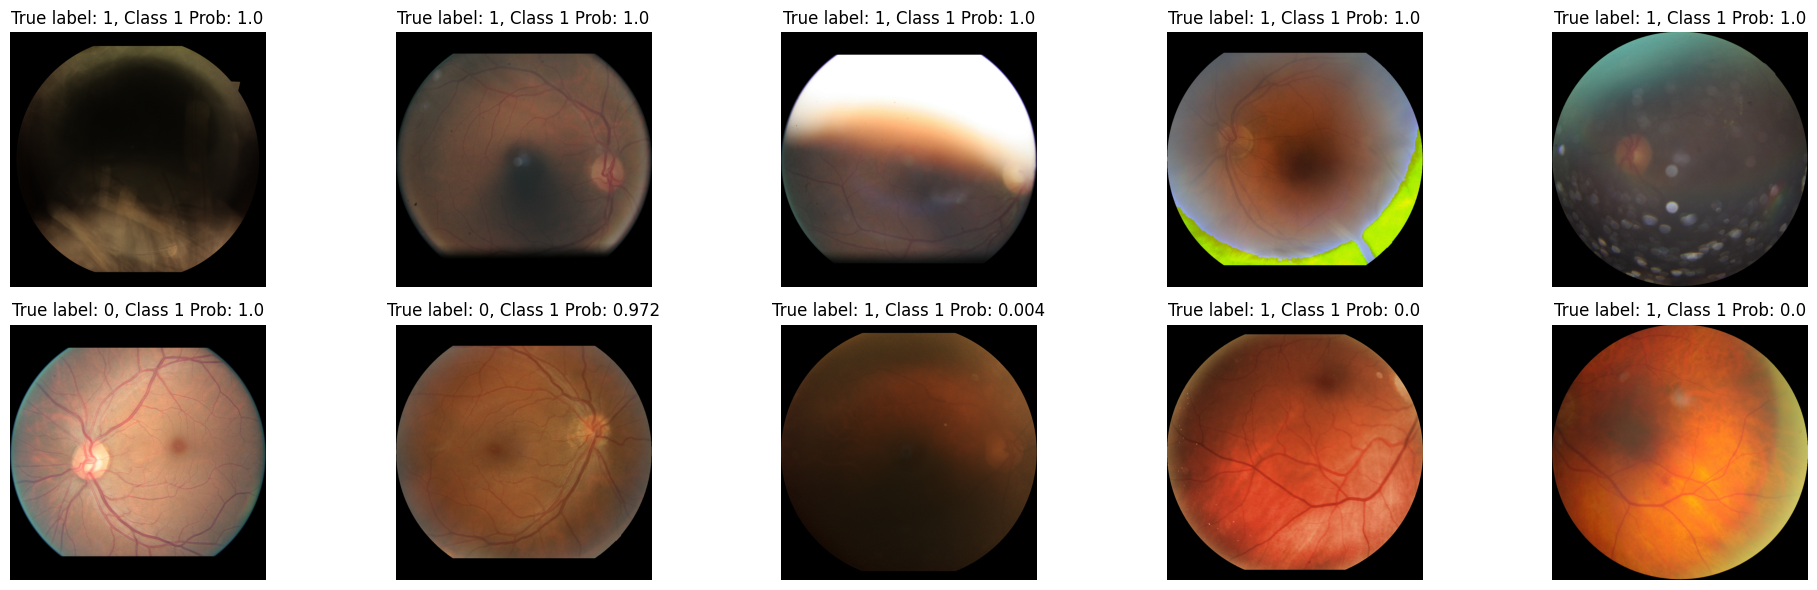

In [64]:
def plot_predictions(num_imgs,model_prob_score,y_test):

  '''
  Function for plotting images based on model's confidence
  '''

  assert len(model_prob_score) == len(y_test), "Model's prob score and y_test length should be same"

  # storing filenames of correct and incorrect predictions
  correct_labels = []
  incorrect_labels = []

  for (class_0_prob,class_1_prob), (filename,label) in zip(model_prob_score,y_test):

    pred_label = 0 if class_0_prob > class_1_prob else 1 ## taking max on both the class probabilities
    
    if pred_label == label: ## correct prediction
      correct_labels.append((filename,label,class_1_prob))

    else:
      incorrect_labels.append((filename,label,class_1_prob))


  correct_labels_sort = sorted(correct_labels, key  = lambda x : x[2],reverse = True)
  incorrect_labels_sort = sorted(incorrect_labels, key =  lambda x : x[2],reverse = True)

  # print(len(incorrect_labels_sort))

  fig, axs = plt.subplots(2, num_imgs, figsize=(20, 6))

  # Plot correct predictions
  for i in range(num_imgs):
      axs[0, i].imshow(img_di[correct_labels_sort[i][0]])
      axs[0, i].set_title(f"True label: {correct_labels_sort[i][1]}, Class 1 Prob: {round(correct_labels_sort[i][2],3)}")
      axs[0, i].axis("off")

  # Plot incorrect predictions
  for i in range(num_imgs):
      axs[1, i].imshow(img_di[incorrect_labels_sort[i][0]])
      axs[1, i].set_title(f"True label: {incorrect_labels_sort[i][1]}, Class 1 Prob: {round(incorrect_labels_sort[i][2],3)}")
      axs[1, i].axis("off")


  fig.tight_layout()
  plt.show()


############## Explanation ###############
#### Row 1: shows the correct predictions by the model
#### Row 2: shows the incorrect predictions by the model

# True label means the ground truth given
# Class 1 Prob means the model's probability score for predicting class 1

## testing code
plot_predictions(5,y_prob_score,y_test) 

### Q: Improvements 

Describe what steps, if any, should be taken to make the model perform better.

### Your Answer:

* Even though the logistic regression model is giving decent result in terms of accuracy, it would be better to reduce the dimensionality of the input feature space as it is huge (1920000 vs 240 train records) compared to number of train records

* Tune reguralization parameter (C) via grid search or some other hyperparameter tuning framework

# Step 2: CNN Model

In this section, we will train a CNN model to classify the images into good and bad classes using the larger data subset. This dataset has 1000 images good (label 0) and bad (label 1) classes. Feel free to use any model including 
pre-trained models. 

## Q: Loss function

Your model predicts the quality of an image. At this step we have two classes: good and bad. Tell us which loss function you will be using & why?

### Your Answer:


I'll be using binary cross entropy (bce) loss for modelling as it measures the dissimilarity betweeen the predicted probability distribution and the true probability distribution.

Here the task is to predict the probability of bad image which can be interpreted as likelihood of a given instance belonging to that class. Binary cross entropy is designed to penalize models that assign low probabilities to true class and high probilities to the negative class 

## Q: Train the model

### Your Answer:

In [8]:
img_di,label_di = load_images(image_path,cnn_subset_path)

1000it [00:15, 65.04it/s]


In [173]:
cnn_data = []

for (filename,img),(filename,label) in zip(img_di.items(),label_di.items()):
  data_dict = {}
  data_dict['image'] = img
  data_dict['label'] = label
  data_dict['name'] = filename

  cnn_data.append(data_dict)

len(cnn_data)

1000

In [174]:
# Define device to use for training (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [175]:
#############  Defining model layout ###########


# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

### modifying VGG
class vggModel(nn.Module):
  '''
  Adding 2 extra fully connected layers at the end of pre trained VGG network
  '''
  def __init__(self,vgg16_model,linear_1,linear_2):
    super(vggModel,self).__init__()
    self.vgg16_model = vgg16_model
    relu = nn.ReLU(inplace = True)
    self.final_layer = nn.Sequential( linear_1,relu,linear_2)

  def forward(self,x):
    x = self.vgg16_model(x)
    x1 = self.final_layer(x)
    return x1.squeeze()

model = vggModel(vgg16,torch.nn.Linear(1000, 256) , (torch.nn.Linear(256, 2)))

## Allowing last 2 layers of the fully connected (pre trained layers) VGG network to be updated 
model.vgg16_model.classifier[-1].weight.requires_grad = True
model.vgg16_model.classifier[-4].weight.requires_grad = True

# # Replace the last layer with a new trainable layer
# in_features = vgg16.classifier[-1].in_features
# # vgg16.classifier[-1] = nn.Linear(in_features, 1)

model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


vggModel(
  (vgg16_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [176]:
# print(dir(model.final_layer[0])),model.final_layer[0].weight.requires_grad

In [177]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [178]:
### Defining class for dataset

class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([ transforms.ToTensor(),
                                              transforms.Resize(224),                                              
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                          ]) 
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]['image']
        label = self.data[index]['label']
        filename = self.data[index]['name']
        img = self.transform(img)
        return img, label,filename


### train, test split of dataset

train_data,test_data = train_test_split(cnn_data, test_size=0.2, random_state = 42)

len(cnn_data),len(train_data),len(test_data)

(1000, 800, 200)

In [179]:
# Create ImageDataset object
train_dataset = ImageDataset(train_data)
valid_dataset = ImageDataset(test_data)

# Define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)


In [180]:
# Train the model 

history = []

for epoch in range(20):

    running_loss = 0.0
    model.train()

    correct_train,total_train = 0,0

    for i, data in tqdm(enumerate(train_loader, 0)):
        inputs, labels , _ = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        
        # outputs = torch.argmax(outputs,dim= 1)
        # print(inputs.shape,outputs.shape,labels.shape)

        one_hot = torch.nn.functional.one_hot(labels,2).cuda()

        # print(outputs.shape)
        # print(one_hot.shape)

        loss = criterion(outputs.float(), one_hot.float())
        loss.backward()
        optimizer.step()

        total_train += labels.size(0)
        correct_train += (torch.argmax(outputs,dim= 1) == labels).sum().item()

        running_loss += loss.item()
    
    correct = 0
    total = 0
    model.eval()
    running_loss_val = 0.0

    with torch.no_grad():

        for data in valid_loader:
            images, labels, _ = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            predicted = torch.argmax(outputs,dim= 1)

            one_hot = torch.nn.functional.one_hot(labels,2).cuda()

            val_loss = criterion(outputs.float(), one_hot.float())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss_val +=val_loss.item()

    
    print(f'epoch : {epoch}, train loss: {running_loss/ len(train_loader)}, val loss: {running_loss_val/len(valid_loader)} ')
    print(f'train acc: {(100 * correct_train / total_train)}, val acc: {(100 * correct / total)} ')
    history.append((epoch,running_loss/ len(train_loader),running_loss_val/len(valid_loader)))


0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
13it [00:09,  1.39it/s]


epoch : 0, train loss: 0.626060834297767, val loss: 0.5345390439033508 
train acc: 67.875, val acc: 76.5 


13it [00:08,  1.49it/s]


epoch : 1, train loss: 0.5255366701346177, val loss: 0.4993748962879181 
train acc: 75.25, val acc: 78.0 


13it [00:11,  1.13it/s]


epoch : 2, train loss: 0.4932574721483084, val loss: 0.4990806430578232 
train acc: 78.125, val acc: 77.0 


13it [00:08,  1.46it/s]


epoch : 3, train loss: 0.4716574755998758, val loss: 0.4810577630996704 
train acc: 77.5, val acc: 77.5 


13it [00:09,  1.39it/s]


epoch : 4, train loss: 0.44453097077516407, val loss: 0.48443150520324707 
train acc: 80.5, val acc: 77.5 


13it [00:09,  1.37it/s]


epoch : 5, train loss: 0.4601423190190242, val loss: 0.5053314417600632 
train acc: 76.75, val acc: 73.5 


13it [00:09,  1.39it/s]


epoch : 6, train loss: 0.438377130490083, val loss: 0.4586680084466934 
train acc: 79.625, val acc: 78.0 


13it [00:09,  1.39it/s]


epoch : 7, train loss: 0.38757392993340123, val loss: 0.46003638207912445 
train acc: 81.75, val acc: 76.0 


13it [00:08,  1.48it/s]


epoch : 8, train loss: 0.3736566580258883, val loss: 0.4731828570365906 
train acc: 82.375, val acc: 75.0 


13it [00:08,  1.50it/s]


epoch : 9, train loss: 0.36410528192153346, val loss: 0.45070385932922363 
train acc: 83.25, val acc: 77.5 


13it [00:09,  1.38it/s]


epoch : 10, train loss: 0.3394421155636127, val loss: 0.4841127246618271 
train acc: 84.5, val acc: 77.5 


13it [00:09,  1.35it/s]


epoch : 11, train loss: 0.34265899428954494, val loss: 0.4837733954191208 
train acc: 86.375, val acc: 78.0 


13it [00:09,  1.37it/s]


epoch : 12, train loss: 0.3276030788054833, val loss: 0.4468937814235687 
train acc: 86.625, val acc: 77.5 


13it [00:09,  1.38it/s]


epoch : 13, train loss: 0.3116069401686008, val loss: 0.46223121881484985 
train acc: 86.25, val acc: 78.0 


13it [00:09,  1.39it/s]


epoch : 14, train loss: 0.29457901188960445, val loss: 0.4955127090215683 
train acc: 86.25, val acc: 79.0 


13it [00:08,  1.48it/s]


epoch : 15, train loss: 0.3129576868735827, val loss: 0.4956645369529724 
train acc: 86.125, val acc: 77.0 


13it [00:08,  1.50it/s]


epoch : 16, train loss: 0.28130217355031234, val loss: 0.4648747891187668 
train acc: 87.875, val acc: 77.5 


13it [00:09,  1.42it/s]


epoch : 17, train loss: 0.28821515578490037, val loss: 0.45422692596912384 
train acc: 88.5, val acc: 79.0 


13it [00:09,  1.38it/s]


epoch : 18, train loss: 0.26988485570137316, val loss: 0.48731786012649536 
train acc: 87.125, val acc: 79.0 


13it [00:09,  1.38it/s]


epoch : 19, train loss: 0.24497917752999526, val loss: 0.47604505717754364 
train acc: 89.875, val acc: 78.5 


## Q: Training Metrics

Plot the loss and any other metric of interest on the training and validation data. What observations or comments can you making regarding the training job?

### Your Answer:

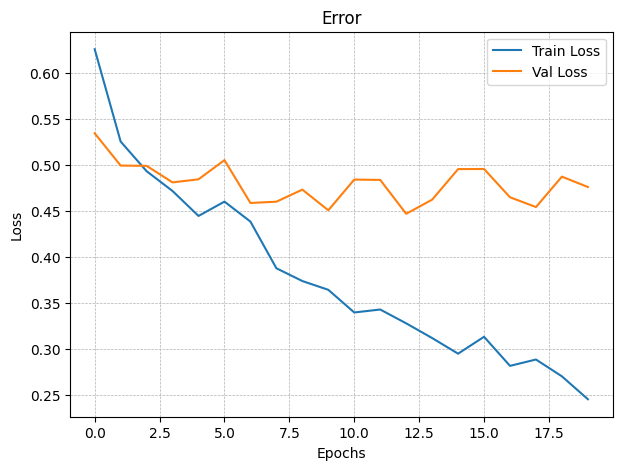

In [181]:
def plot_loss_error(history):

  fig,ax = plt.subplots(1,1,figsize = (7,5))

  ax.plot([epoch for epoch,tra_loss,val_loss in history],[tra_loss for epoch,tra_loss,val_loss in history],color='tab:blue',label= 'Train Loss')
  ax.plot([epoch for epoch,tra_loss,val_loss in history],[val_loss for epoch,tra_loss,val_loss in history],color='tab:orange',label= 'Val Loss')

  ax.legend()
  ax.set_title('Error')
  ax.grid(linestyle = '--',linewidth=0.5)
  
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.show()   

plot_loss_error(history)

## Q: Plotting Predictions
Plot some of model predictions with true labels. Share your insights
### Your Answer:

In [187]:
### Storing model results on the test set in terms of Probability scores

y_test_cnn_tmp = []
cnn_prob_score = []
y_filenames = []

model.eval()
with torch.no_grad():

    for data in valid_loader:
        images, labels,filenames = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        cnn_prob_score.extend(outputs.to('cpu').numpy().tolist())
        y_test_cnn_tmp.extend(labels.to('cpu').numpy().tolist())
        y_filenames.extend(filenames)

# cnn_prob_score = [e[0] for e in cnn_prob_score]

len(y_test_cnn_tmp),len(cnn_prob_score ),len(y_filenames)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(200, 200, 200)

In [188]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

cnn_prob_score = [softmax(row) for row in cnn_prob_score] 

In [189]:
cnn_prob_score = [list(e) for e in cnn_prob_score]
y_test_cnn = [(name,label) for name,label in zip(y_filenames,y_test_cnn_tmp)]

In [172]:
# y_test_cnn[:10],cnn_prob_score[:10]

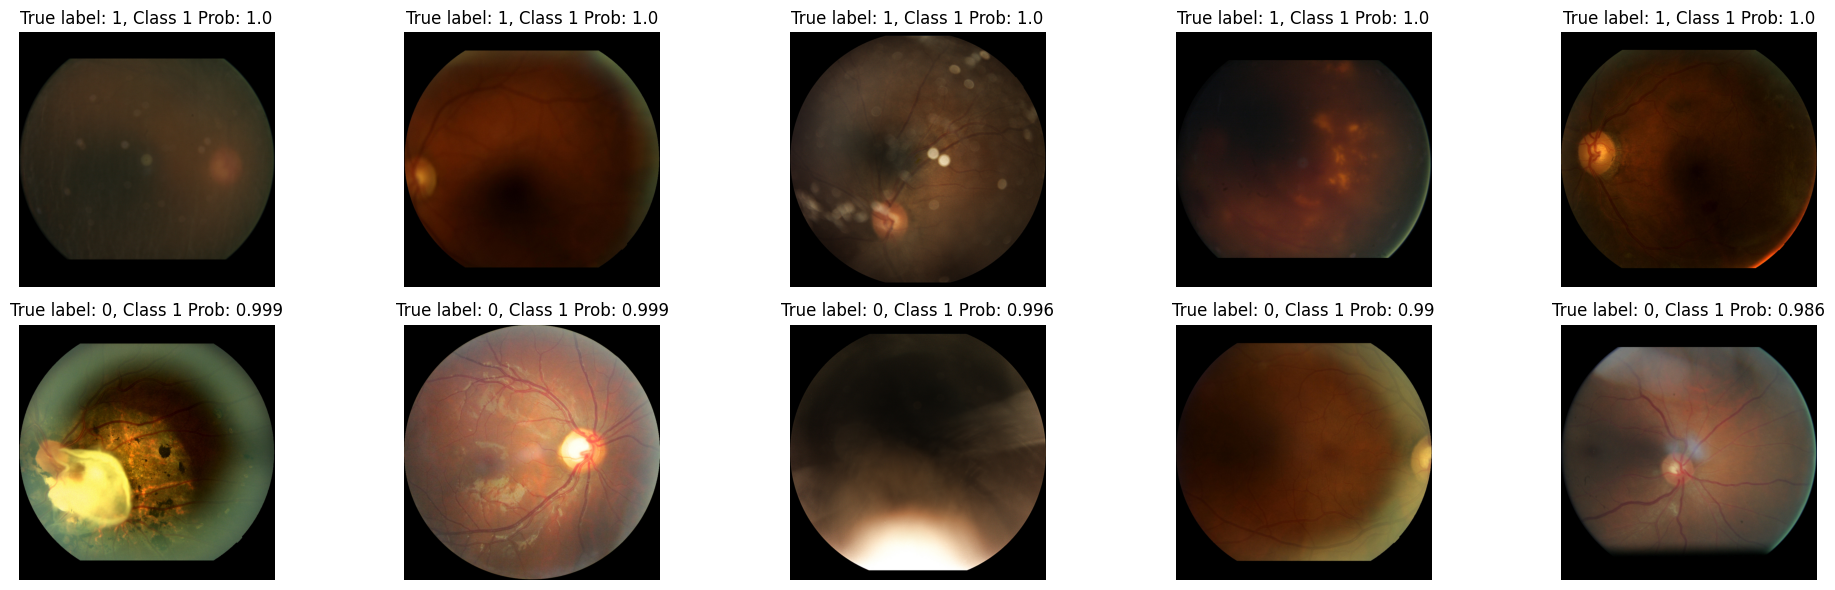

In [192]:
def plot_cnn_predictions(num_imgs,model_prob_score,y_test):

  '''
  Function for plotting images based on model's confidence
  '''

  assert len(model_prob_score) == len(y_test), "Model's prob score and y_test length should be same"

  # storing filenames of correct and incorrect predictions
  correct_labels = []
  incorrect_labels = []

  for (class_0_prob,class_1_prob), (filename,label) in zip(model_prob_score,y_test):

    pred_label = 0 if class_0_prob > class_1_prob else 1 ## taking max on both the class probabilities
    
    if pred_label == label: ## correct prediction
      correct_labels.append((filename,label,class_1_prob))

    else:
      incorrect_labels.append((filename,label,class_1_prob))


  correct_labels_sort = sorted(correct_labels, key  = lambda x : x[2],reverse = True)
  incorrect_labels_sort = sorted(incorrect_labels, key =  lambda x : x[2],reverse = True)

  # print(len(incorrect_labels_sort),len(correct_labels_sort))

  fig, axs = plt.subplots(2, num_imgs, figsize=(20, 6))

  # Plot correct predictions
  for i in range(num_imgs):
      axs[0, i].imshow(img_di[correct_labels_sort[i][0]])
      axs[0, i].set_title(f"True label: {correct_labels_sort[i][1]}, Class 1 Prob: {round(correct_labels_sort[i][2],3)}")
      axs[0, i].axis("off")

  # Plot incorrect predictions
  for i in range(num_imgs):
      axs[1, i].imshow(img_di[incorrect_labels_sort[i][0]])
      axs[1, i].set_title(f"True label: {incorrect_labels_sort[i][1]}, Class 1 Prob: {round(incorrect_labels_sort[i][2],3)}")
      axs[1, i].axis("off")


  fig.tight_layout()
  plt.show()


############## Explanation ###############
#### Row 1: shows the correct predictions by the model
#### Row 2: shows the incorrect predictions by the model

# True label means the ground truth given
# Class 1 Prob means the model's probability score for predicting class 1

## testing code
plot_cnn_predictions(5,cnn_prob_score,y_test_cnn)  #y_test_cnn[:10],cnn_prob_score[:10]

## Q: Improvements
Describe what steps, if any, should be taken to make the model perform better. If you have time, try to sort any issues that you've identified and train a new model. Feel free to write your own functions in the notebook to inspect / correct the training data, if necessary. 
- Is your model making any obvious errors? 
- Compare the results of the CNN model with the simple model you trained earlier. Comment on the outcome of this comparison.

### Your Answer:

* Diverging train and val loss suggests that the model is overfitting on the data. One way to overcome this would be to use dropouts during training.
* Most of the errors are false postives, which means the model thinks they are positive (poor quality images) but the experts think it is good images. To me who is not an expert in this field, feels that the model's output is correct for the 2nd row (incorrect predictions) especially 1st, 3rd and 4th images which are quite blurry therefore their ground truth should be 1 instead of zero. One can recheck with the experts to further validate the model's result.

* It would be bit unfair to compare the results of simpler model vs cnn model as the data description suggests that the two sets are mutually exclusive. Also by looking at the results where models are incorrectly classifying results, I get a feeling that the CNN set is more difficult or incorrectly labeled. One strategy, to compare would be to use 300 images of the simple set as a final production level test set to have apples to apples comparison.

# Step 3: Multi-level Classification

In this stage, consider building a model to predict the image quality with multiple class labels: good, accept and bad. You are not expected to provide code or achieve perfection! Rather, we would like to at least see in writing what next steps you think are useful and why. Specifically, try to address:
- What methods you would implement from a model and/or data preprocessing standpoint
- What challenges you foresee in implementing your selected model and/or data preprocessing approach
- How you would evaluate a model that predicts these 3-class labels against the previous models?

* One of the methods could be to look at the probabilty scores of the models and bucket the images into 3 clases based on some approximate threshold initially and then validating the threshold by labelling them. This would speed up the labelling process and create new set acceptable set. Ex: 0 to 0.3 probabilty score images can be put in good quality bucket and 0.7 to 1 in bad quality bucket. For the left out images pick the ones with score less than 0.5 and use it as acceptable bucket. Manually label 10 to 50 samples from each bucket and move the threshold accordingly.


* The above method would be difficult to find the accepatable bucket thresholds. Also, it might be challenging to tackle the false positive cases as seen in the above examples.

* One could compare the performance of 3 class (multi level) classification model with binary classification model by removing all the records from the groundtruth which had new extra class and calculating the same metric which was used for binary classification model.

# Rough work

In [ ]:
# #############  Defining model layout ###########


# # Load the pre-trained VGG16 model
# vgg16 = models.vgg16(pretrained=True)

# # Freeze all layers
# for param in vgg16.parameters():
#     param.requires_grad = False


# ### modifying VGG
# class vggModel(nn.Module):

#   def __init__(self,vgg16_model,linear_1,linear_2):
#     super(vggModel,self).__init__()
#     self.vgg16_model = vgg16_model
#     self.linear1 = linear_1
#     self.linear2 = linear_2

#   def forward(self,x):
#     x = self.vgg16_model(x)

#     x1 = self.linear1(x)

#     x2 = self.linear2(x1)

#     # print(type(x2),x2.size())

#     return x2.squeeze()

# model = vggModel(vgg16,nn.Sequential(
#             torch.nn.Linear(1000, 2)
#             ),nn.Sequential(
#             torch.nn.Sigmoid()
#             ))

# # # Replace the last layer with a new trainable layer
# # in_features = vgg16.classifier[-1].in_features
# # # vgg16.classifier[-1] = nn.Linear(in_features, 1)

# model.to(device)
